# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
torch.set_float32_matmul_precision('high')
from train import *

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:

def simulate_BM(n_sample, dt, n_timestep):
    noise = torch.randn(size=(n_sample, n_timestep))
    paths_incr = noise * torch.sqrt(torch.tensor(dt))
    paths = torch.cumsum(paths_incr, axis=1)
    BM_paths = torch.cat([torch.zeros((n_sample, 1)), paths], axis=1)
    BM_paths = BM_paths[..., None]
    return BM_paths


def simulate_BS(n_sample, dt, n_timestep, mu, sigma):
    time_grid = torch.linspace(0, dt * n_timestep, n_timestep + 1)
    time_paths = time_grid.expand([n_sample, n_timestep + 1])[..., None]
    BM_paths = simulate_BM(n_sample, dt, n_timestep)
    BS_paths = torch.exp(sigma * BM_paths + (mu - 0.5 * sigma**2) * time_paths - 5)
    return BS_paths


start_date = '1990-01-01'
end_date = '2023-01-01'

t = pd.date_range(start=start_date, end=end_date)
n_timestep = len(t)
df = pd.DataFrame({'Date': t, 'spx': t})
df.set_index('Date', inplace=True)
dt = 1/12
mu = 0.1
sigma = 0.2
BS_paths = simulate_BS(1, dt, n_timestep-1, mu, sigma)
path = BS_paths[0,:,0].numpy().astype(np.float64)
df['spx'] = path
# df.to_csv('data/bs.csv')
df.to_csv('data/spx.csv')

# df = pd.read_csv('data/spx.csv', index_col=0, parse_dates=True)
# df.info()
df = pd.read_csv('data/bs.csv', index_col=0, parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16806 entries, 2000-01-01 to >>>>>>> refs/remotes/origin/main
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     16803 non-null  float64
dtypes: float64(1)
memory usage: 262.6+ KB


In [4]:
# samples
batch_size = 256 # number of samples in each batch
sample_len = 61 # length of each sample
sample_model = 'Realdt' # GBM, Heston, OU, RealData, Realdt, spx_rates
lead_lag = False # whether to use lead lag transformation
lags = [1] # number of lags to use for lead lag transformation: int or list[int]
seed = 42


# BS
batch_size = 64 # number of samples in each batch
sample_len = 61 # length of each sample
stride = 60


# real data parameters
# stride = 50 # for real data
# start_date = '1995-01-01' # start date for real data
# end_date = '2918-09-18' # end date for real data


In [5]:
# signature kernel
static_kernel_type = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels = 5 # number of levels in the truncated signature kernel

# generator
seq_dim = 1 # dimension of sequence vector
activation = 'Tanh' # pytorch names e.g. Tanh, ReLU. NOTE: does NOT change transformer layers'
hidden_size = 64
n_lstm_layers = 1 # number of LSTM layers
conditional = True # feed in history for LSTM generators
hist_len = 11

In [6]:
noise_dim = 1 # dimension of noise vector
ma = True # whether to use MA noise generator fitted to log returns gaussianized by Lambert W transformation
ma_p = 5

### Training Related

In [7]:
epochs = 300 # number of batches
start_lr = 0.001 # starting learning rate
patience = 100 # number of epochs to wait before reducing lr
lr_factor = 0.5 # factor to multiply lr by for scheduler
early_stopping = patience*3 # number of epochs to wait before no improvement
kernel_sigma = 0.2 # starting kernel_sigma
num_losses = 20

### Save to tensorboard log

In [8]:
# save all parameters to a dictionary
rng = np.random.default_rng(seed)
torch.manual_seed(seed)

data_params, model_params, train_params = get_params_dicts(vars().copy())

# save parameters to tensorboard
writer = start_writer(data_params, model_params, train_params)

### Data, kernel, generator

In [9]:
dataloader = get_dataloader(**{**data_params, **model_params, 'bs':True})
kernel = get_signature_kernel(**{**model_params, **train_params})
generator = get_generator(**{**model_params, **data_params})
generator.to(device)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 17101.765483623356
            Iterations: 11
            Function evaluations: 92
            Gradient evaluations: 11
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -17101.8
Distribution:                  Normal   AIC:                           34215.5
Method:            Maximum Likelihood   BIC:                           34259.9
                                        No. Observations:                12053
Date:                Tue, Sep 03 2024   Df Residuals:                    12053
Time:                        09:47:47   Df Model:                            0
                               Volatility Model                              
 

/home/luchungi/miniconda3/envs/signature/lib/python3.11/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/home/luchungi/miniconda3/envs/signature/lib/python3.11/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/home/luchungi/miniconda3/envs/signature/lib/python3.11/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

GenLSTM(
  (rnn): LSTM(3, 64, batch_first=True)
  (mean_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (var_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (output_net): Linear(in_features=64, out_features=1, bias=True)
)

In [10]:
len(dataloader.dataset)

200

2
torch.Size([64, 61, 2])
torch.Size([64, 60, 1])


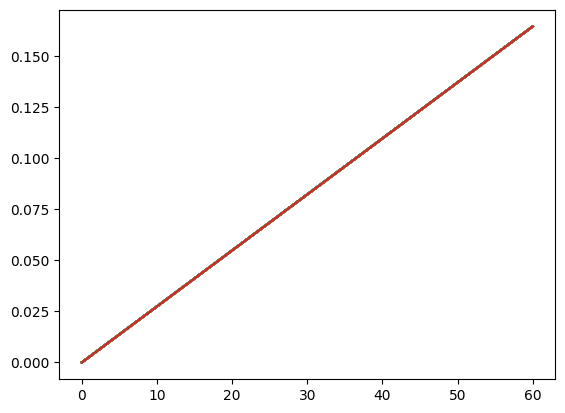

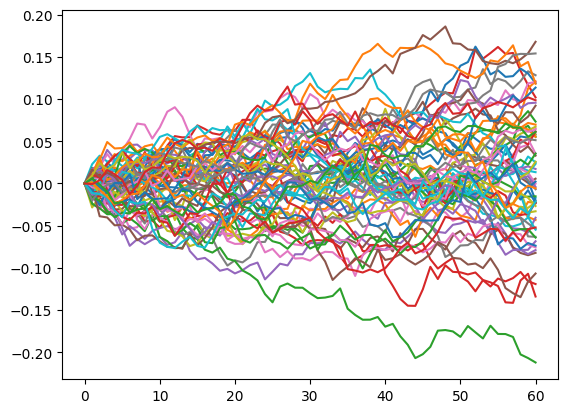

In [11]:
# Visualize data
for item in dataloader:
    print(len(item))
    print(item[0].shape)
    print(item[1].shape)
    break
plt.plot(item[0][:,:,0].T)
plt.show()
plt.plot(item[0][:,:,1].T)
plt.show()

# Train MMD-GAN

In [12]:
train(generator, kernel, dataloader, rng, writer, device, **{**train_params, **model_params, **data_params})

/home/luchungi/miniconda3/envs/signature/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


Epoch 0, loss: 460.2120768229167, avg_last_20_loss: 460.2120768229167
Saving model at epoch 0


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 1, loss: 150.65515899658203, avg_last_20_loss: 305.4336179097494
Saving model at epoch 1


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epoch 2, loss: 13.305980841318766, avg_last_20_loss: 208.05773888693918
Saving model at epoch 2


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epoch 3, loss: 6.094666083653768, avg_last_20_loss: 157.56697068611783
Saving model at epoch 3


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epoch 4, loss: 32.975850423177086, avg_last_20_loss: 132.6487466335297
Saving model at epoch 4


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epoch 5, loss: 34.159036000569664, avg_last_20_loss: 116.23379486136969
Saving model at epoch 5


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 6, loss: 14.397119681040445, avg_last_20_loss: 101.68569840703694
Saving model at epoch 6


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 7, loss: 3.8853023846944175, avg_last_20_loss: 89.46064890424411
Saving model at epoch 7


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epoch 8, loss: 0.9239003658294678, avg_last_20_loss: 79.62323239997582
Saving model at epoch 8


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 9, loss: 0.6377394199371338, avg_last_20_loss: 71.72468310197195
Saving model at epoch 9


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epoch 10, loss: 1.3404591083526611, avg_last_20_loss: 65.3261172843702
Saving model at epoch 10


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epoch 11, loss: 1.9728885491689045, avg_last_20_loss: 60.04668155643676
Saving model at epoch 11


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epoch 12, loss: 2.558642784754435, avg_last_20_loss: 55.62452472784581
Saving model at epoch 12


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 13, loss: 2.3926145235697427, avg_last_20_loss: 51.82224542754037
Saving model at epoch 13


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 14, loss: 2.2761852741241455, avg_last_20_loss: 48.51917475064595
Saving model at epoch 14


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epoch 15, loss: 1.3038203716278076, avg_last_20_loss: 45.56821510195733
Saving model at epoch 15


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 16, loss: 0.9896120230356852, avg_last_20_loss: 42.945944332608995
Saving model at epoch 16


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 17, loss: 0.5971023241678873, avg_last_20_loss: 40.5932308876956
Saving model at epoch 17


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 18, loss: 0.5310419400533041, avg_last_20_loss: 38.48469462729337
Saving model at epoch 18


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 19, loss: 0.5576883951822916, avg_last_20_loss: 36.58834431568782
Saving model at epoch 19


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 20, loss: 0.608251174290975, avg_last_20_loss: 13.608153033256531
Saving model at epoch 20


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 21, loss: 0.7085649172465006, avg_last_20_loss: 6.110823329289754
Saving model at epoch 21


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 22, loss: 0.5308833122253418, avg_last_20_loss: 5.472068452835083
Saving model at epoch 22


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epoch 23, loss: 0.7567586104075114, avg_last_20_loss: 5.205173079172771
Saving model at epoch 23


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epoch 24, loss: 0.7755124568939209, avg_last_20_loss: 3.595156180858612
Saving model at epoch 24


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 25, loss: 0.57431960105896, avg_last_20_loss: 1.9159203608830768
Saving model at epoch 25


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 26, loss: 0.5363313357035319, avg_last_20_loss: 1.2228809436162313
Saving model at epoch 26


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epoch 27, loss: 0.5016963481903076, avg_last_20_loss: 1.053700641791026
Saving model at epoch 27


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 28, loss: 0.4035039742787679, avg_last_20_loss: 1.0276808222134908
Saving model at epoch 28


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epoch 29, loss: 0.5826567014058431, avg_last_20_loss: 1.0249266862869262
Saving model at epoch 29


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epoch 30, loss: 0.6143956184387207, avg_last_20_loss: 0.9886235117912291
Saving model at epoch 30


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 31, loss: 0.5720467567443848, avg_last_20_loss: 0.9185814221700032
Saving model at epoch 31


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epoch 32, loss: 0.4887377421061198, avg_last_20_loss: 0.8150861700375875
Saving model at epoch 32


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 33, loss: 0.508271058400472, avg_last_20_loss: 0.7208689967791239
Saving model at epoch 33


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 34, loss: 0.45609156290690106, avg_last_20_loss: 0.6298643112182616
Saving model at epoch 34


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 35, loss: 0.6065396467844645, avg_last_20_loss: 0.5950002749760945
Saving model at epoch 35


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Epoch 36, loss: 0.6920955975850424, avg_last_20_loss: 0.5801244537035624
Saving model at epoch 36


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch 37, loss: 0.49688053131103516, avg_last_20_loss: 0.5751133640607198
Saving model at epoch 37


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


Epoch 38, loss: 0.5585453510284424, avg_last_20_loss: 0.5764885346094767


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epoch 39, loss: 0.4636693795522054, avg_last_20_loss: 0.5717875838279725
Saving model at epoch 39


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 40, loss: 0.4761659304300944, avg_last_20_loss: 0.5651833216349283
Saving model at epoch 40


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 41, loss: 0.3769555886586507, avg_last_20_loss: 0.5486028552055359
Saving model at epoch 41


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 42, loss: 0.46029241879781085, avg_last_20_loss: 0.5450733105341594
Saving model at epoch 42


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 43, loss: 0.44876821835835773, avg_last_20_loss: 0.5296737909317016
Saving model at epoch 43


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 44, loss: 0.403600533803304, avg_last_20_loss: 0.511078194777171
Saving model at epoch 44


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 45, loss: 0.41938432057698566, avg_last_20_loss: 0.5033314307530722
Saving model at epoch 45


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epoch 46, loss: 0.43760331471761066, avg_last_20_loss: 0.49839502970377614
Saving model at epoch 46


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 47, loss: 0.3968471686045329, avg_last_20_loss: 0.4931525707244873
Saving model at epoch 47


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 48, loss: 0.3400731086730957, avg_last_20_loss: 0.48998102744420374
Saving model at epoch 48


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 49, loss: 0.4875790278116862, avg_last_20_loss: 0.48522714376449577
Saving model at epoch 49


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 50, loss: 0.36870725949605304, avg_last_20_loss: 0.4729427258173625
Saving model at epoch 50


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 51, loss: 0.3433695634206136, avg_last_20_loss: 0.46150886615117387
Saving model at epoch 51


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 52, loss: 0.5336229801177979, avg_last_20_loss: 0.4637531280517579


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 53, loss: 0.45008166631062824, avg_last_20_loss: 0.4608436584472656
Saving model at epoch 53


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 54, loss: 0.32421040534973145, avg_last_20_loss: 0.45424960056940716
Saving model at epoch 54


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 55, loss: 0.4101196924845378, avg_last_20_loss: 0.44442860285441077
Saving model at epoch 55


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 56, loss: 0.31397199630737305, avg_last_20_loss: 0.4255224227905273
Saving model at epoch 56


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 57, loss: 0.4201797644297282, avg_last_20_loss: 0.421687384446462
Saving model at epoch 57


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 58, loss: 0.31942296028137207, avg_last_20_loss: 0.40973126490910855
Saving model at epoch 58


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 59, loss: 0.4110724925994873, avg_last_20_loss: 0.4071014205614725
Saving model at epoch 59


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epoch 60, loss: 0.3406636714935303, avg_last_20_loss: 0.40032630761464444
Saving model at epoch 60


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 61, loss: 0.36562561988830566, avg_last_20_loss: 0.3997598091761271
Saving model at epoch 61


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 62, loss: 0.3386325041453044, avg_last_20_loss: 0.3936768134435018
Saving model at epoch 62


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 63, loss: 0.3620444933573405, avg_last_20_loss: 0.3893406271934509
Saving model at epoch 63


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 64, loss: 0.4184470971425374, avg_last_20_loss: 0.39008295536041265


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 65, loss: 0.37636709213256836, avg_last_20_loss: 0.3879320939381917
Saving model at epoch 65


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 66, loss: 0.2737275759379069, avg_last_20_loss: 0.3797383069992065
Saving model at epoch 66


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 67, loss: 0.30507508913675946, avg_last_20_loss: 0.37514970302581785
Saving model at epoch 67


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 68, loss: 0.27018046379089355, avg_last_20_loss: 0.3716550707817078
Saving model at epoch 68


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 69, loss: 0.260222593943278, avg_last_20_loss: 0.3602872490882874
Saving model at epoch 69


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 70, loss: 0.28314677874247235, avg_last_20_loss: 0.35600922505060834
Saving model at epoch 70


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 71, loss: 0.24460824330647787, avg_last_20_loss: 0.3510711590449015
Saving model at epoch 71


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 72, loss: 0.30901432037353516, avg_last_20_loss: 0.3398407260576884
Saving model at epoch 72


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 73, loss: 0.30264949798583984, avg_last_20_loss: 0.332469117641449
Saving model at epoch 73


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epoch 74, loss: 0.31397557258605957, avg_last_20_loss: 0.33195737600326536
Saving model at epoch 74


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch 75, loss: 0.3002668221791585, avg_last_20_loss: 0.32646473248799646
Saving model at epoch 75


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 76, loss: 0.34160327911376953, avg_last_20_loss: 0.3278462966283162


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 77, loss: 0.27963511149088544, avg_last_20_loss: 0.3208190639813741
Saving model at epoch 77


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch 78, loss: 0.2848967711130778, avg_last_20_loss: 0.31909275452295943
Saving model at epoch 78


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epoch 79, loss: 0.21007450421651205, avg_last_20_loss: 0.30904285510381063
Saving model at epoch 79


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 80, loss: 0.3015898863474528, avg_last_20_loss: 0.3070891658465068
Saving model at epoch 80


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 81, loss: 0.26163530349731445, avg_last_20_loss: 0.3018896500269572
Saving model at epoch 81


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epoch 82, loss: 0.2639295260111491, avg_last_20_loss: 0.29815450112024944
Saving model at epoch 82


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 83, loss: 0.24932519594828287, avg_last_20_loss: 0.2925185362497966
Saving model at epoch 83


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 84, loss: 0.24780646959940592, avg_last_20_loss: 0.28398650487264004
Saving model at epoch 84


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 85, loss: 0.22762592633565268, avg_last_20_loss: 0.27654944658279423
Saving model at epoch 85


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epoch 86, loss: 0.3036805788675944, avg_last_20_loss: 0.27804709672927863


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 87, loss: 0.18112476666768393, avg_last_20_loss: 0.2718495806058248
Saving model at epoch 87


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 88, loss: 0.20400277773539224, avg_last_20_loss: 0.2685406963030497
Saving model at epoch 88


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Epoch 89, loss: 0.23952190081278482, avg_last_20_loss: 0.2675056616465251
Saving model at epoch 89


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 90, loss: 0.20342079798380533, avg_last_20_loss: 0.26351936260859177
Saving model at epoch 90


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 91, loss: 0.25647584597269696, avg_last_20_loss: 0.2641127427419027


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 92, loss: 0.2274472713470459, avg_last_20_loss: 0.26003439029057823
Saving model at epoch 92


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 93, loss: 0.24035859107971191, avg_last_20_loss: 0.2569198449452718
Saving model at epoch 93


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 94, loss: 0.23193097114562988, avg_last_20_loss: 0.25281761487325033
Saving model at epoch 94


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 95, loss: 0.23404701550801596, avg_last_20_loss: 0.24950662453969316
Saving model at epoch 95


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 96, loss: 0.2017972469329834, avg_last_20_loss: 0.2425163229306539
Saving model at epoch 96


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 97, loss: 0.1757074991861979, avg_last_20_loss: 0.23731994231541953
Saving model at epoch 97


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 98, loss: 0.13394840558369955, avg_last_20_loss: 0.2297725240389506
Saving model at epoch 98


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 99, loss: 0.2075643539428711, avg_last_20_loss: 0.22964701652526856
Saving model at epoch 99


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 100, loss: 0.18514013290405273, avg_last_20_loss: 0.22382452885309853
Saving model at epoch 100


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch 101, loss: 0.16163245836893717, avg_last_20_loss: 0.21882438659667974
Saving model at epoch 101


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 102, loss: 0.18874025344848633, avg_last_20_loss: 0.21506492296854654
Saving model at epoch 102


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 103, loss: 0.2191161314646403, avg_last_20_loss: 0.2135544697443644
Saving model at epoch 103


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 104, loss: 0.16066082318623862, avg_last_20_loss: 0.20919718742370602
Saving model at epoch 104


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 105, loss: 0.1536416212717692, avg_last_20_loss: 0.2054979721705119
Saving model at epoch 105


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epoch 106, loss: 0.2220491568247477, avg_last_20_loss: 0.20141640106836953
Saving model at epoch 106


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 107, loss: 0.14602883656819662, avg_last_20_loss: 0.19966160456339516
Saving model at epoch 107


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epoch 108, loss: 0.1738468805948893, avg_last_20_loss: 0.19815380970637003
Saving model at epoch 108


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 109, loss: 0.16858712832132974, avg_last_20_loss: 0.19460707108179726
Saving model at epoch 109


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epoch 110, loss: 0.139433224995931, avg_last_20_loss: 0.19140769243240358
Saving model at epoch 110


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 111, loss: 0.14287328720092773, avg_last_20_loss: 0.18572756449381508
Saving model at epoch 111


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 112, loss: 0.12649242083231607, avg_last_20_loss: 0.18067982196807858
Saving model at epoch 112


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epoch 113, loss: 0.13404536247253418, avg_last_20_loss: 0.17536416053771972
Saving model at epoch 113


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 114, loss: 0.1534104347229004, avg_last_20_loss: 0.17143813371658323
Saving model at epoch 114


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epoch 115, loss: 0.13960766792297363, avg_last_20_loss: 0.16671616633733113
Saving model at epoch 115


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 116, loss: 0.11821969350179036, avg_last_20_loss: 0.1625372886657715
Saving model at epoch 116


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epoch 117, loss: 0.15862607955932617, avg_last_20_loss: 0.1616832176844279
Saving model at epoch 117


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 118, loss: 0.11590687433878581, avg_last_20_loss: 0.16078114112218223
Saving model at epoch 118


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 119, loss: 0.10536885261535645, avg_last_20_loss: 0.15567136605580648
Saving model at epoch 119


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 120, loss: 0.08017436663309734, avg_last_20_loss: 0.1504230777422587
Saving model at epoch 120


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 121, loss: 0.10959641138712566, avg_last_20_loss: 0.14782127539316808
Saving model at epoch 121


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 122, loss: 0.10815366109212239, avg_last_20_loss: 0.14379194577534993
Saving model at epoch 122


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 123, loss: 0.10044145584106445, avg_last_20_loss: 0.13785821199417111
Saving model at epoch 123


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 124, loss: 0.08379491170247395, avg_last_20_loss: 0.13401491641998292
Saving model at epoch 124


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 125, loss: 0.08882339795430501, avg_last_20_loss: 0.1307740052541097
Saving model at epoch 125


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 126, loss: 0.09318971633911133, avg_last_20_loss: 0.12433103322982789
Saving model at epoch 126


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 127, loss: 0.0868227481842041, avg_last_20_loss: 0.12137072881062827
Saving model at epoch 127


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 128, loss: 0.08258787790934245, avg_last_20_loss: 0.1168077786763509
Saving model at epoch 128


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 129, loss: 0.06434170405069987, avg_last_20_loss: 0.11159550746281939
Saving model at epoch 129


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 130, loss: 0.10543290774027507, avg_last_20_loss: 0.1098954916000366
Saving model at epoch 130


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epoch 131, loss: 0.0644981066385905, avg_last_20_loss: 0.10597673257191975
Saving model at epoch 131


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 132, loss: 0.10416086514790852, avg_last_20_loss: 0.10486015478769939
Saving model at epoch 132


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epoch 133, loss: 0.06805483500162761, avg_last_20_loss: 0.10156062841415406
Saving model at epoch 133


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epoch 134, loss: 0.07947254180908203, avg_last_20_loss: 0.09786373376846315
Saving model at epoch 134


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 135, loss: 0.08372664451599121, avg_last_20_loss: 0.09506968259811402
Saving model at epoch 135


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 136, loss: 0.0981450875600179, avg_last_20_loss: 0.0940659523010254
Saving model at epoch 136


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epoch 137, loss: 0.04962770144144694, avg_last_20_loss: 0.08861603339513142
Saving model at epoch 137


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 138, loss: 0.0397024949391683, avg_last_20_loss: 0.08480581442515055
Saving model at epoch 138


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 139, loss: 0.08278330167134602, avg_last_20_loss: 0.08367653687795003
Saving model at epoch 139


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 140, loss: 0.05013068517049154, avg_last_20_loss: 0.08217435280481974
Saving model at epoch 140


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epoch 141, loss: 0.04566852251688639, avg_last_20_loss: 0.07897795836130776
Saving model at epoch 141


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 142, loss: 0.04551966985066732, avg_last_20_loss: 0.07584625879923503
Saving model at epoch 142


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 143, loss: 0.10723241170247395, avg_last_20_loss: 0.07618580659230549


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 144, loss: 0.04366898536682129, avg_last_20_loss: 0.07417951027552286
Saving model at epoch 144


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 145, loss: 0.0267945130666097, avg_last_20_loss: 0.0710780660311381
Saving model at epoch 145


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epoch 146, loss: 0.04406309127807617, avg_last_20_loss: 0.06862173477808634
Saving model at epoch 146


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 147, loss: 0.03435373306274414, avg_last_20_loss: 0.06599828402201334
Saving model at epoch 147


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 148, loss: 0.021141211191813152, avg_last_20_loss: 0.06292595068613688
Saving model at epoch 148


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 149, loss: 0.029166539510091145, avg_last_20_loss: 0.06116719245910644
Saving model at epoch 149


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 150, loss: 0.02646613121032715, avg_last_20_loss: 0.05721885363260905
Saving model at epoch 150


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 151, loss: 0.018782695134480793, avg_last_20_loss: 0.054933083057403555
Saving model at epoch 151


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 152, loss: 0.02283056577046712, avg_last_20_loss: 0.050866568088531496
Saving model at epoch 152


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 153, loss: 0.022562106450398762, avg_last_20_loss: 0.04859193166097006
Saving model at epoch 153


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 154, loss: 0.01743038495381673, avg_last_20_loss: 0.04548982381820679
Saving model at epoch 154


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epoch 155, loss: 0.014331181844075521, avg_last_20_loss: 0.04202005068461101
Saving model at epoch 155


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 156, loss: 0.021063963572184246, avg_last_20_loss: 0.038165994485219325
Saving model at epoch 156


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 157, loss: 0.017311652501424152, avg_last_20_loss: 0.03655019203821819
Saving model at epoch 157


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 158, loss: 0.016206661860148113, avg_last_20_loss: 0.03537540038426717
Saving model at epoch 158


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epoch 159, loss: 0.0131227175394694, avg_last_20_loss: 0.03189237117767334
Saving model at epoch 159


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 160, loss: 0.01867190996805827, avg_last_20_loss: 0.030319432417551674
Saving model at epoch 160


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 161, loss: 0.014976739883422852, avg_last_20_loss: 0.028784843285878492
Saving model at epoch 161


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 162, loss: 0.011437257130940756, avg_last_20_loss: 0.027080722649892176
Saving model at epoch 162


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 163, loss: 0.014755328496297201, avg_last_20_loss: 0.022456868489583334
Saving model at epoch 163


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 164, loss: 0.007425149281819661, avg_last_20_loss: 0.02064467668533325
Saving model at epoch 164


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 165, loss: 0.011399666468302408, avg_last_20_loss: 0.019874934355417883
Saving model at epoch 165


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 166, loss: 0.016562779744466145, avg_last_20_loss: 0.018499918778737384
Saving model at epoch 166


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 167, loss: 0.0076685746510823565, avg_last_20_loss: 0.017165660858154297
Saving model at epoch 167


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 168, loss: 0.006982485453287761, avg_last_20_loss: 0.016457724571228027
Saving model at epoch 168


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epoch 169, loss: 0.010625918706258139, avg_last_20_loss: 0.015530693531036375
Saving model at epoch 169


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 170, loss: 0.0032002131144205728, avg_last_20_loss: 0.014367397626241049
Saving model at epoch 170


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 171, loss: 0.012606938680013021, avg_last_20_loss: 0.014058609803517658
Saving model at epoch 171


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 172, loss: 0.004023551940917969, avg_last_20_loss: 0.0131182591120402
Saving model at epoch 172


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epoch 173, loss: 0.004972219467163086, avg_last_20_loss: 0.012238764762878418
Saving model at epoch 173


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epoch 174, loss: 0.0025835037231445312, avg_last_20_loss: 0.011496420701344809
Saving model at epoch 174


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Epoch 175, loss: 0.0018986066182454426, avg_last_20_loss: 0.010874791940053304
Saving model at epoch 175


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epoch 176, loss: 0.011094411214192709, avg_last_20_loss: 0.010376314322153728
Saving model at epoch 176


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epoch 177, loss: -0.00031503041585286457, avg_last_20_loss: 0.009494980176289877
Saving model at epoch 177


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epoch 178, loss: 0.003083467483520508, avg_last_20_loss: 0.008838820457458497
Saving model at epoch 178


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 179, loss: 0.0054492950439453125, avg_last_20_loss: 0.008455149332682292
Saving model at epoch 179


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epoch 180, loss: 0.0013539791107177734, avg_last_20_loss: 0.0075892527898152665
Saving model at epoch 180


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 181, loss: 0.001759926478068034, avg_last_20_loss: 0.0069284121195475265
Saving model at epoch 181


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epoch 182, loss: 0.004213253657023112, avg_last_20_loss: 0.006567211945851642
Saving model at epoch 182


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Epoch 183, loss: -0.0015760262807210286, avg_last_20_loss: 0.0057506442070007335
Saving model at epoch 183


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epoch 184, loss: -0.0014546712239583333, avg_last_20_loss: 0.005306653181711833
Saving model at epoch 184


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epoch 185, loss: -0.0015603701273600261, avg_last_20_loss: 0.004658651351928712
Saving model at epoch 185


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 186, loss: 0.005812883377075195, avg_last_20_loss: 0.004121156533559164
Saving model at epoch 186


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 187, loss: 0.004989306131998698, avg_last_20_loss: 0.003987193107604981
Saving model at epoch 187


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epoch 188, loss: 0.009542306264241537, avg_last_20_loss: 0.00411518414815267


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epoch 189, loss: 0.0003342628479003906, avg_last_20_loss: 0.0036006013552347823
Saving model at epoch 189


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epoch 190, loss: 0.0041798750559488935, avg_last_20_loss: 0.0036495844523111985


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch 191, loss: 0.0022039413452148438, avg_last_20_loss: 0.003129434585571289
Saving model at epoch 191


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Epoch 192, loss: 0.0015372435251871746, avg_last_20_loss: 0.0030051191647847493
Saving model at epoch 192


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 193, loss: 0.0051421324412028, avg_last_20_loss: 0.003013614813486735


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epoch 194, loss: 0.003991127014160156, avg_last_20_loss: 0.003083995978037516


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 195, loss: -0.00010903676350911458, avg_last_20_loss: 0.002983613808949788
Saving model at epoch 195


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 196, loss: -0.0009357134501139323, avg_last_20_loss: 0.0023821075757344563
Saving model at epoch 196


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 197, loss: 0.0007334550221761068, avg_last_20_loss: 0.0024345318476359052


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 198, loss: 0.003022273381551107, avg_last_20_loss: 0.002431472142537435


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 199, loss: 0.009682655334472656, avg_last_20_loss: 0.0026431401570638025


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 200, loss: 0.0042684078216552734, avg_last_20_loss: 0.0027888615926106772


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epoch 201, loss: -0.0025528271993001304, avg_last_20_loss: 0.0025732239087422693


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 202, loss: 0.009222030639648438, avg_last_20_loss: 0.002823662757873535


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epoch 203, loss: 0.0004707177480061849, avg_last_20_loss: 0.002925999959309896


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epoch 204, loss: 0.0023081302642822266, avg_last_20_loss: 0.0031141400337219237


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 205, loss: -0.000997304916381836, avg_last_20_loss: 0.0031422932942708334


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 206, loss: 0.0005392233530680338, avg_last_20_loss: 0.002878610293070475


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch 207, loss: -0.0030983289082845054, avg_last_20_loss: 0.002474228541056315


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 208, loss: 0.0011664231618245442, avg_last_20_loss: 0.002055434385935465
Saving model at epoch 208


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch 209, loss: 0.002805630366007487, avg_last_20_loss: 0.0021790027618408202


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epoch 210, loss: -0.00018366177876790365, avg_last_20_loss: 0.0019608259201049803
Saving model at epoch 210


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epoch 211, loss: 0.0036978721618652344, avg_last_20_loss: 0.0020355224609374997


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 212, loss: 0.0007301171620686849, avg_last_20_loss: 0.0019951661427815752


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 213, loss: 0.0006055831909179688, avg_last_20_loss: 0.0017683386802673344
Saving model at epoch 213


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 214, loss: -0.00022149085998535156, avg_last_20_loss: 0.0015577077865600586
Saving model at epoch 214


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Epoch 215, loss: -0.001150369644165039, avg_last_20_loss: 0.0015056411425272622
Saving model at epoch 215


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch 216, loss: -0.0011788209279378254, avg_last_20_loss: 0.0014934857686360677
Saving model at epoch 216


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epoch 217, loss: -0.002475182215372721, avg_last_20_loss: 0.0013330539067586261
Saving model at epoch 217


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epoch 218, loss: -0.003353754679361979, avg_last_20_loss: 0.001014252503712972
Saving model at epoch 218


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 219, loss: -0.0036439895629882812, avg_last_20_loss: 0.0003479202588399252
Saving model at epoch 219


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epoch 220, loss: 0.0015133221944173176, avg_last_20_loss: 0.0002101659774780272
Saving model at epoch 220


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epoch 221, loss: -2.7418136596679688e-05, avg_last_20_loss: 0.0003364364306131998


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epoch 222, loss: 0.001295646031697591, avg_last_20_loss: -5.988279978434251e-05
Saving model at epoch 222


100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


Epoch 223, loss: -0.0008182525634765625, avg_last_20_loss: -0.00012433131535847988
Saving model at epoch 223


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Epoch 224, loss: -0.0014282067616780598, avg_last_20_loss: -0.00031114816665649413
Saving model at epoch 224


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch 225, loss: -0.0014259020487467449, avg_last_20_loss: -0.0003325780232747396
Saving model at epoch 225


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


Epoch 226, loss: -0.00035579999287923175, avg_last_20_loss: -0.0003773291905721029
Saving model at epoch 226


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 227, loss: 0.0010305245717366536, avg_last_20_loss: -0.00017088651657104492


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 228, loss: 0.001363833745320638, avg_last_20_loss: -0.00016101598739624024


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 229, loss: -0.0031925042470296225, avg_last_20_loss: -0.0004609227180480958
Saving model at epoch 229


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 230, loss: -0.0029242833455403647, avg_last_20_loss: -0.0005979537963867189
Saving model at epoch 230


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 231, loss: 0.006508588790893555, avg_last_20_loss: -0.0004574179649353027


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 232, loss: -0.0001442432403564453, avg_last_20_loss: -0.0005011359850565593


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 233, loss: -0.002588033676147461, avg_last_20_loss: -0.0006608168284098307
Saving model at epoch 233


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Epoch 234, loss: -0.00168609619140625, avg_last_20_loss: -0.0007340470949808757
Saving model at epoch 234


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


Epoch 235, loss: -0.002683877944946289, avg_last_20_loss: -0.0008107225100199382
Saving model at epoch 235


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 236, loss: -0.0037155946095784507, avg_last_20_loss: -0.0009375611941019694
Saving model at epoch 236


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 237, loss: -0.002474705378214518, avg_last_20_loss: -0.0009375373522440593


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 238, loss: -0.001096645991007487, avg_last_20_loss: -0.0008246819178263348


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 239, loss: -0.0007215340932210287, avg_last_20_loss: -0.0006785591443379719


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 240, loss: -0.0016954739888509114, avg_last_20_loss: -0.0008389989535013836


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 241, loss: -0.0023825963338216147, avg_last_20_loss: -0.0009567578633626301
Saving model at epoch 241


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 242, loss: 0.0017292499542236328, avg_last_20_loss: -0.0009350776672363279


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 243, loss: -0.002965688705444336, avg_last_20_loss: -0.0010424494743347167
Saving model at epoch 243


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 244, loss: 0.0025580724080403647, avg_last_20_loss: -0.0008431355158487957


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 245, loss: 0.0004687309265136719, avg_last_20_loss: -0.0007484038670857747


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 246, loss: -0.0032046635945638022, avg_last_20_loss: -0.0008908470471700033


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epoch 247, loss: -0.0019071896870930989, avg_last_20_loss: -0.0010377327601114909


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 248, loss: -0.0008207956949869791, avg_last_20_loss: -0.0011469642321268716
Saving model at epoch 248


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 249, loss: 0.0015230178833007812, avg_last_20_loss: -0.0009111881256103516


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epoch 250, loss: 0.002067724863688151, avg_last_20_loss: -0.0006615877151489259


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epoch 251, loss: 0.00029587745666503906, avg_last_20_loss: -0.0009722232818603516


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch 252, loss: -0.0005576610565185547, avg_last_20_loss: -0.0009928941726684568


100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Epoch 253, loss: 0.0035706361134847007, avg_last_20_loss: -0.0006849606831868488


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epoch 254, loss: -0.0026138623555501304, avg_last_20_loss: -0.000731348991394043


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 255, loss: -0.00044353802998860675, avg_last_20_loss: -0.0006193319956461589


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epoch 256, loss: 0.0062122344970703125, avg_last_20_loss: -0.0001229405403137207


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 257, loss: 0.003014246622721354, avg_last_20_loss: 0.00015150705973307292


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epoch 258, loss: 0.002180178960164388, avg_last_20_loss: 0.0003153483072916668


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 259, loss: -0.0028809706370035806, avg_last_20_loss: 0.00020737648010253916


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


Epoch 260, loss: 0.00018207232157389322, avg_last_20_loss: 0.00030125379562377934


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epoch 261, loss: 0.0048770904541015625, avg_last_20_loss: 0.0006642381350199382


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Epoch 262, loss: -0.0008478164672851562, avg_last_20_loss: 0.0005353848139444987


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epoch 263, loss: -0.002379894256591797, avg_last_20_loss: 0.0005646745363871257


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch 264, loss: -0.002168575922648112, avg_last_20_loss: 0.00032834211985270184


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 265, loss: 0.002731800079345703, avg_last_20_loss: 0.00044149557749430344


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch 266, loss: 0.003839254379272461, avg_last_20_loss: 0.0007936914761861164


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch 267, loss: 0.004949331283569336, avg_last_20_loss: 0.0011365175247192382


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epoch 268, loss: -0.0005620320638020834, avg_last_20_loss: 0.001149455706278483


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch 269, loss: -0.001873334248860677, avg_last_20_loss: 0.0009796380996704103


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 270, loss: 0.008870840072631836, avg_last_20_loss: 0.0013197938601175944


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 271, loss: 0.0015130043029785156, avg_last_20_loss: 0.0013806502024332683


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epoch 272, loss: 0.015911976496378582, avg_last_20_loss: 0.002204132080078125


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 273, loss: 0.012560129165649414, avg_last_20_loss: 0.002653606732686361


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 274, loss: 0.011701424916585287, avg_last_20_loss: 0.0033693710962931314


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 275, loss: -0.0019699732462565103, avg_last_20_loss: 0.003293049335479736


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 276, loss: 0.0007860660552978516, avg_last_20_loss: 0.003021740913391114


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 277, loss: 6.039937337239583e-06, avg_last_20_loss: 0.002871330579121908


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 278, loss: 0.0016129016876220703, avg_last_20_loss: 0.002842966715494792


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 279, loss: 5.9604644775390625e-06, avg_last_20_loss: 0.002987313270568848


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 280, loss: 0.0014866987864176433, avg_last_20_loss: 0.0030525445938110354


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 281, loss: 0.0026578903198242188, avg_last_20_loss: 0.002941584587097168


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 282, loss: -0.002807458241780599, avg_last_20_loss: 0.0028436024983723956


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epoch 283, loss: 0.00762176513671875, avg_last_20_loss: 0.0033436854680379225


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch 284, loss: 0.0008414586385091146, avg_last_20_loss: 0.0034941871960957847


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Epoch 285, loss: -0.0026268959045410156, avg_last_20_loss: 0.003226252396901449


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 286, loss: -0.0013538201649983723, avg_last_20_loss: 0.002966598669687907


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 287, loss: 0.009815375010172525, avg_last_20_loss: 0.0032099008560180662


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 288, loss: -0.001882791519165039, avg_last_20_loss: 0.0031438628832499193


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 289, loss: -3.250439961751302e-05, avg_last_20_loss: 0.0032359043757120773


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 290, loss: -0.0020706653594970703, avg_last_20_loss: 0.0026888291041056315


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 291, loss: -0.003739515940348307, avg_last_20_loss: 0.0024262030919392904


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 292, loss: -0.0025742053985595703, avg_last_20_loss: 0.0015018939971923827


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 293, loss: 0.0001220703125, avg_last_20_loss: 0.000879991054534912


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 294, loss: -0.001251220703125, avg_last_20_loss: 0.00023235877354939777


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 295, loss: 0.0007703304290771484, avg_last_20_loss: 0.00036937395731608067


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epoch 296, loss: -0.0022710164388020835, avg_last_20_loss: 0.0002165198326110839


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epoch 297, loss: 0.000892798105875651, avg_last_20_loss: 0.0002608577410380045


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epoch 298, loss: -0.002873977025349935, avg_last_20_loss: 3.651380538940419e-05


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

Epoch 299, loss: -0.0015905698140462239, avg_last_20_loss: -4.331270853678396e-05


In [13]:
# dict = torch.load('runs/Sep01_20-18-02_ada-29_rq_10/generator.pt', map_location=torch.device('cpu'))

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


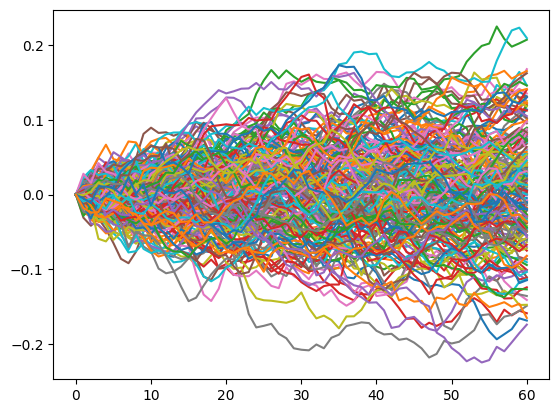

In [14]:
with torch.no_grad():
    for X in tqdm(dataloader):
        if ma: # ma noise is generated for each batch within dataset class
            X, noise = X
            if noise.device != device: noise = noise.to(device)
        else: # Gaussian noise is generated for each batch
            noise = torch.tensor(rng.normal(size=(batch_size, sample_len-1, noise_dim)), device=device, dtype=torch.float32, requires_grad=False)
        X = X.to(device)

        t = X[:,:,:1] # time dimension of path is always first series of the last dim
        if conditional:
            hist_x = X[:,:hist_len,1:] # history portion of path
            output = generator(noise, t, hist_x=hist_x)
            output = torch.cat([t, output], axis=-1) # concatenate time and history + generated path along time series value dimension
            # remove history portion from X and output to compute MMD only on generated path
            X = X[:,hist_len:,:]
            # output = output[:,hist_len:,:]
        else:
            output = generator(noise, t)
            output = torch.cat([t, output], axis=-1) # concatenate time and generated path along time series value dimension

        plt.plot(output[:,:,1].cpu().T)


In [15]:
output[:,hist_len:,1].diff().std() * np.sqrt(365), np.log(df['spx']).diff().std() * np.sqrt(365)

(tensor(0.2050, device='cuda:0'), 0.19978894065926736)

In [16]:
output[:,hist_len:,1].diff().mean() * 365, np.log(df['spx']).diff().mean() * 365

(tensor(0.1256, device='cuda:0'), 0.09098375847944976)

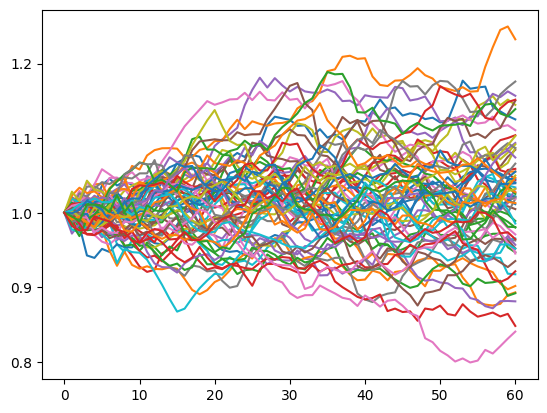

In [17]:
plt.plot(np.exp(output[:,:,1].cpu()).T);